gonna do a feature scoring where x=uncertainties and y=outcomes at each year
then save those as timeseries feature scores

then gonna see how those converge as more scenarios are added in bunches of 100, like at the bottom of AS-AGG

In [40]:
from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [42]:
from plotting import save_fig

### Set-up

In [43]:
no_flood = False

nfl = ""
if no_flood:
    nfl = "no_flood/"

In [44]:
path = f'../results/{nfl}'
file_name = '2000_scen__AGGD_reps__0612__burned_in__with_rates'
file_ext  = '.tar.gz'

In [45]:
results = load_results(path + file_name + file_ext)
experiments, outcomes = results

In [46]:
cols_to_ignore = ['scenario', 'policy', 'model'] 
for col in experiments.columns: 
    if 'Cluster' in col:
        cols_to_ignore.append(col)

uncertainties = [c for c in experiments.columns if c not in cols_to_ignore]
uncertainties

['debt_sales_ratio',
 'wage_sensitivity_prod',
 'init_markup',
 'capital_firm_cap_out_ratio',
 'min_unempl_emigration',
 'migration_unempl_bounds_diff',
 'deu_discount_factor',
 'flood_timing']

In [14]:
oois = [ooi for ooi in outcomes if ooi.count('[') == 0 and 'Change' not in ooi]
oois

['Household Population', 'Gini Coefficient', 'Median Wage', 'GDP']

### Feature Scoring on Final Timestep

In [9]:
final_outcomes = {ooi:[] for ooi in oois}
for ooi in oois:
    runs = outcomes[ooi]
    for run in runs:
        final_outcomes[ooi].append(run[-1])

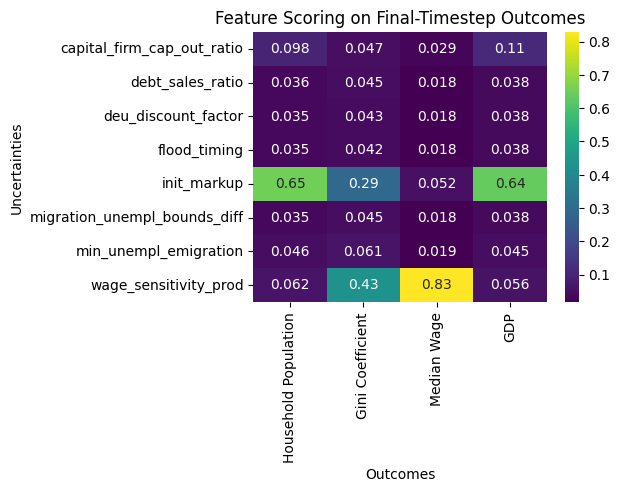

In [10]:
fs = feature_scoring.get_feature_scores_all(experiments[uncertainties], final_outcomes)
sns.heatmap(fs, cmap="viridis", annot=True)

plt.ylabel('Uncertainties')
plt.xlabel('Outcomes')

plt.tight_layout()
save_fig(title='Feature scoring final timestep', dir=f'{nfl}sensitivity/')

plt.title('Feature Scoring on Final-Timestep Outcomes')

plt.show()

### Feature Scoring as a Timeseries

In [47]:
# For now, sample at each year
if 'resampled' in file_name:
    ts = np.arange(len(outcomes['GDP'][0]))
else:
    ts = np.arange(len(outcomes['GDP'][0]), step=4)
ts

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64,
       68, 72, 76, 80, 84, 88, 92, 96])

In [48]:
# fs_tables is a collection of the FS tables for viewing as heatmaps
fs_tables = []
# feature_scores[input][output] is a measure of the importance of input to the output timeseries, over time
feature_scores = {unc:{ooi:[] for ooi in oois} for unc in uncertainties}
for t in ts:
    # Collect outcome measures at time t
    outcomes_t = {ooi:[] for ooi in oois}
    for ooi in oois:
        runs = outcomes[ooi]
        for run in runs:
            outcomes_t[ooi].append(run[t])
    
    # Get feature scores
    fs = feature_scoring.get_feature_scores_all(experiments[uncertainties], outcomes_t)

    # Add scores to timeseries data structures
    fs_tables.append(fs)

    for unc in uncertainties:
        for ooi in oois:
            feature_scores[unc][ooi].append(fs.loc[unc, ooi])

### Plot time-series feature scores

In [13]:
palette = sns.color_palette("tab10", 10)

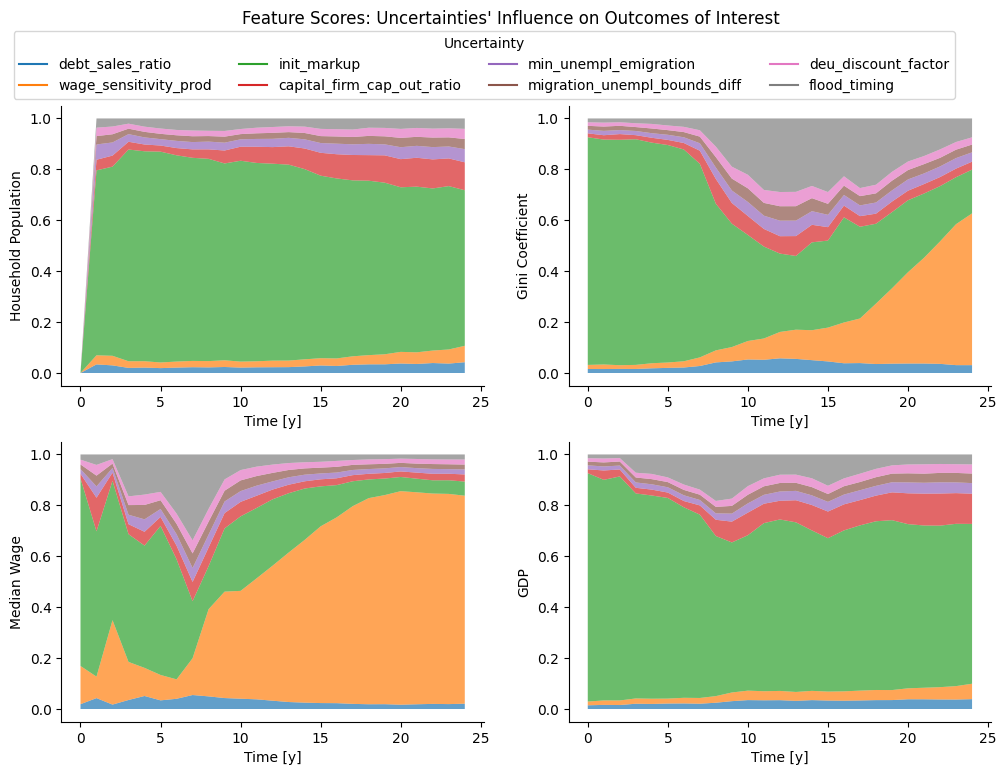

In [49]:
n_rows = len(oois) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))

# Plot lines in each subplot
for i, ooi in enumerate(oois):
    row = i // 2
    col = i % 2
    ax = axes[row][col]

    fs_ts_len = len(feature_scores[uncertainties[0]][ooi])
    x = np.arange(fs_ts_len)
    cumulative_scores = np.zeros(fs_ts_len)

    for u, unc in enumerate(uncertainties):
        # ax.plot(feature_scores[unc][ooi]) #, label=unc)
        ax.fill_between(x, cumulative_scores, cumulative_scores+feature_scores[unc][ooi],
                        facecolor=palette[u], alpha=0.7)
        cumulative_scores += np.array(feature_scores[unc][ooi])

    ax.set_xlabel(f'Time [y]')
    ax.set_ylabel(f'{ooi}')

# Create legend
handles = []
for u, unc in enumerate(uncertainties):
    color = palette[u]
    handles.append(mpl.lines.Line2D(
        [], [], color=color, linestyle='solid', label=unc,
    ))

ax = axes[0][0]
legend = ax.legend(
    title=f'Uncertainty',
    handles=handles,
    bbox_to_anchor=(1,1),
    loc='lower center',
    ncol=len(uncertainties)/2,
)


sns.despine()

save_fig(title='feature scoring timeseries', dir=f'{nfl}sensitivity/')

# Style figure
plt.suptitle(f'Feature Scores: Uncertainties\' Influence on Outcomes of Interest', y=1.00)
plt.show()

### Feature scoring with an incremental experimental design

Repeat the above using incrementally-larger slices of the experimental design such that the number of scenarios needed to cover the input space is evaluated.

In [18]:
N_RUNS = len(experiments)
N_RUNS

2000

In [19]:
len(experiments.loc[:100, uncertainties])

101

In [20]:
len(outcomes['GDP'][:100])

100

In [21]:
# all_feature_scores[N][input][output] is a measure of the importance of input to the output timeseries over time, 
#  taken from the first N "scenarios" (input samples)
all_feature_scores = {N:{unc:{ooi:[] for ooi in oois} for unc in uncertainties} for N in range(100, N_RUNS+1, 100)}

for N in all_feature_scores:
    for t in ts:
        # Collect outcome measures at time t
        outcomes_t = {ooi:[] for ooi in oois}
        for ooi in oois:
            runs = outcomes[ooi][:N]
            for run in runs:
                outcomes_t[ooi].append(run[t])
        
        # Get feature scores
        fs = feature_scoring.get_feature_scores_all(experiments.loc[:N-1, uncertainties], outcomes_t)

        # Add scores to timeseries data structures
        for unc in uncertainties:
            for ooi in oois:
                all_feature_scores[N][unc][ooi].append(fs.loc[unc, ooi])

In [22]:
# Set up colorbar
normalizer = Normalize(100, 2000)
im = cm.ScalarMappable(norm=normalizer)
im.set_cmap('viridis')

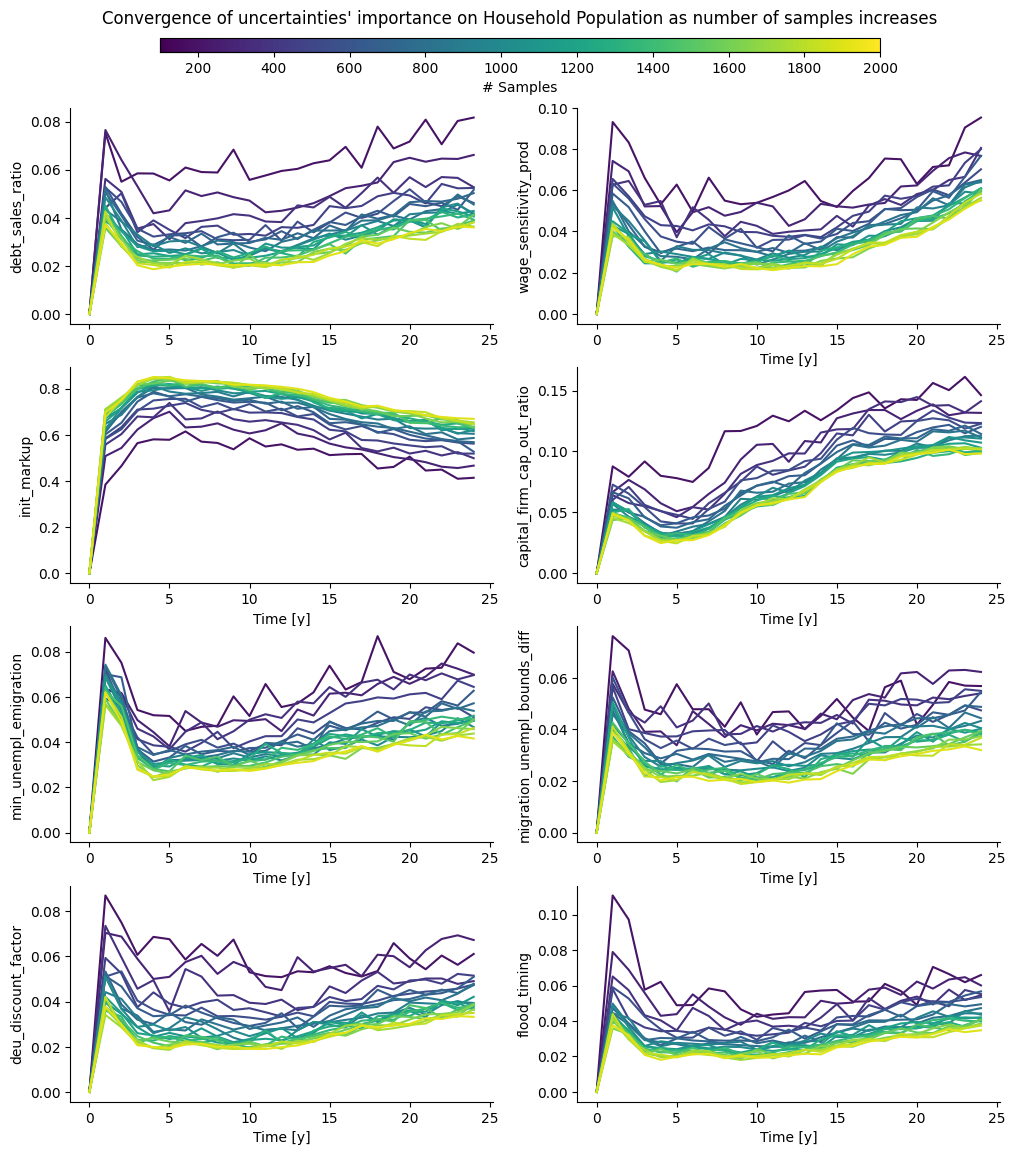

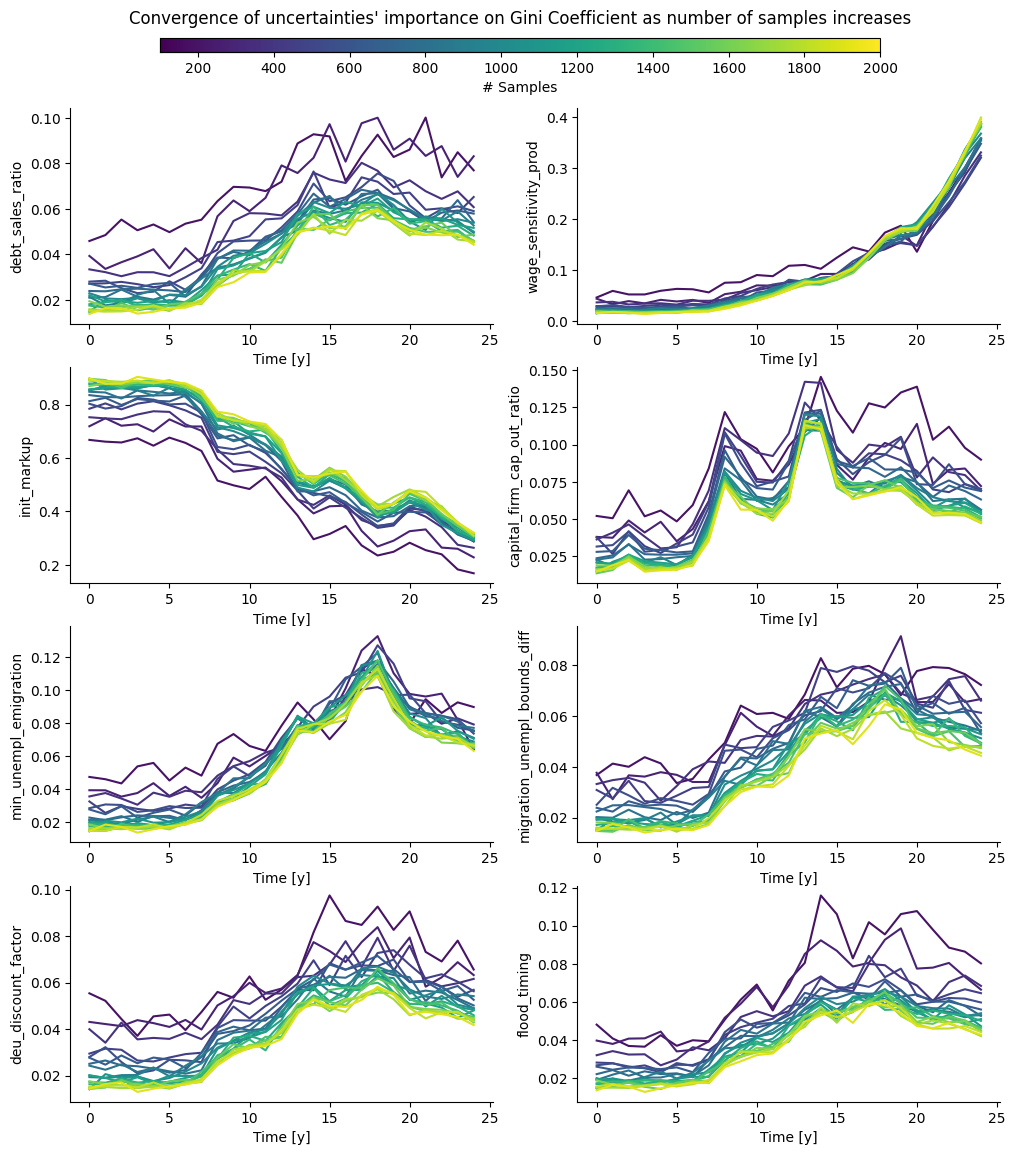

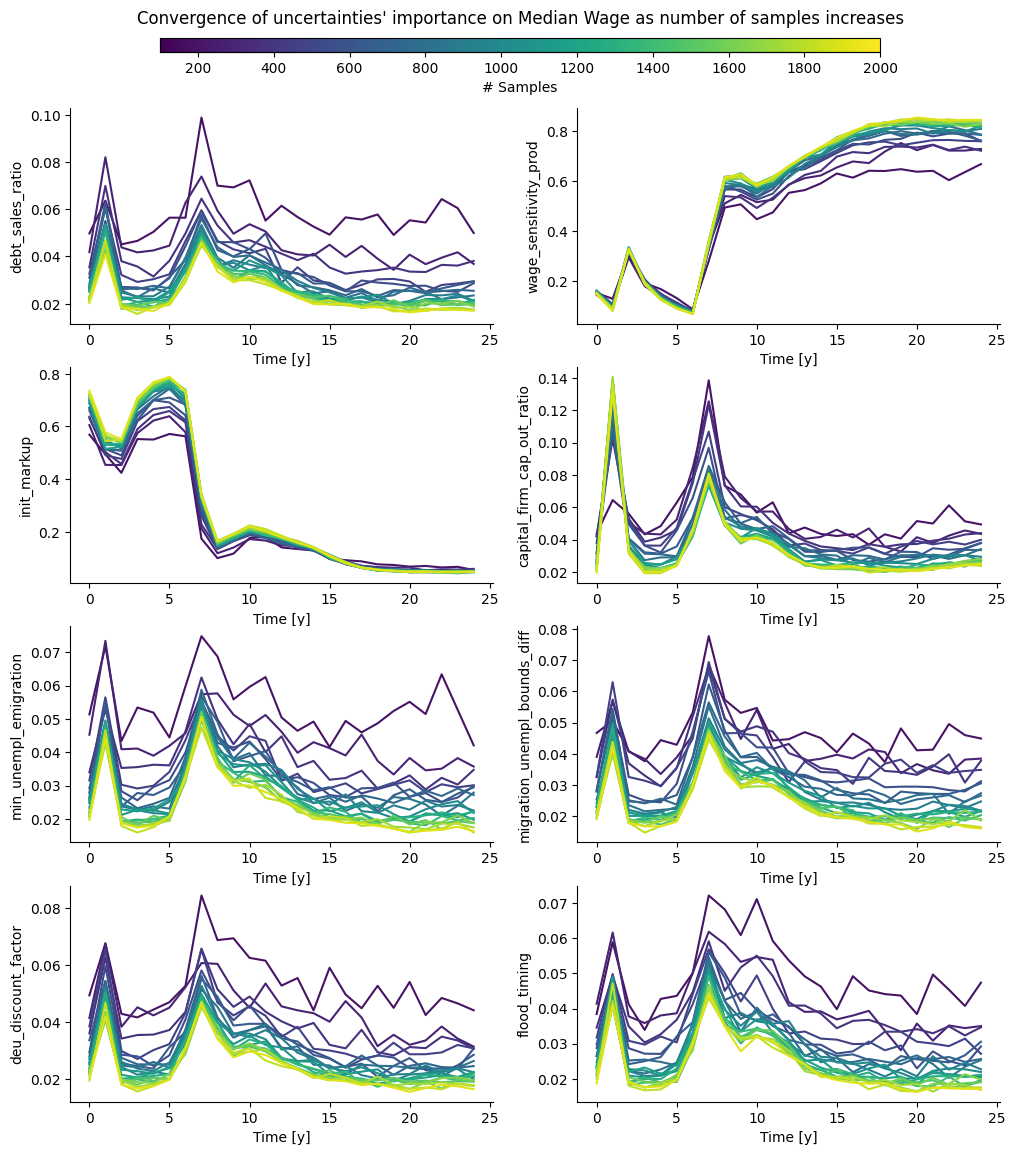

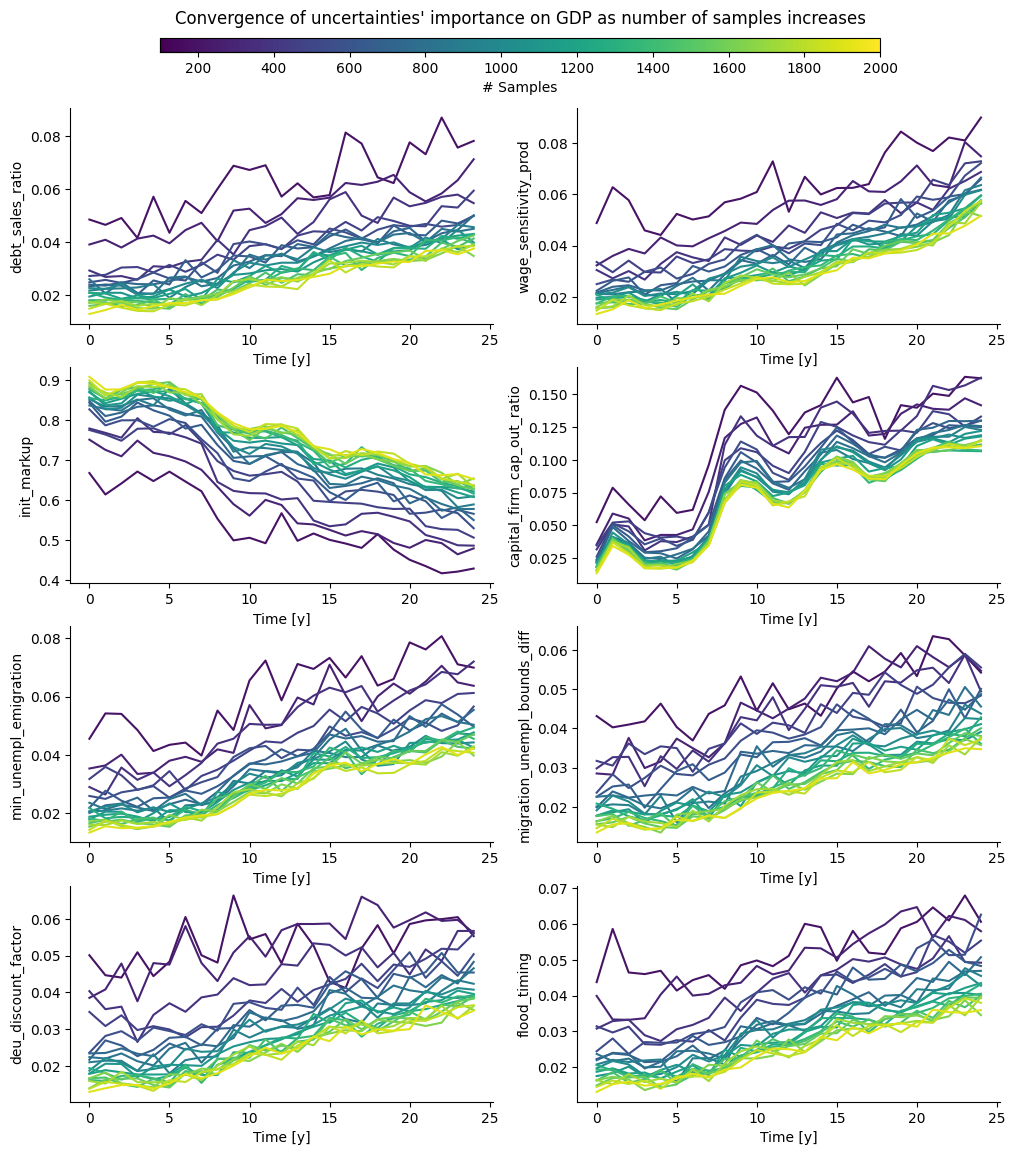

In [23]:
for ooi in oois:
    # Create figure with subplots
    n_rows = (len(uncertainties)+1)//2
    fig, axes = plt.subplots(n_rows, 2, figsize=(12,3.5*n_rows))

    for i, unc in enumerate(uncertainties):
        # Build DF for plotting converging lines
        feature_scores_by_N = {N:all_feature_scores[N][unc][ooi] for N in all_feature_scores}
        feature_scores_by_N_df = pd.DataFrame(feature_scores_by_N)

        # Add lines to plot
        row = i // 2
        col = i % 2
        ax = axes[row][col]

        sns.lineplot(feature_scores_by_N,
                     palette='viridis',
                     dashes=False,
                     legend=False,
                     ax=ax)
        
        ax.set_xlabel('Time [y]')
        ax.set_ylabel(f'{unc}')

    # Present plot
    # if have 8 plots: top=0.82, add_axes[1] = 0.86, add_axes[3]=0.01, suptitle.y=0.89
    # if have 4 plots: top=0.81, add_axes[1] = 0.88, add_axes[3]=0.02, suptitle.y=0.94
    fig.subplots_adjust(top=0.82)
    cbar_ax = fig.add_axes([0.2, 0.86, 0.6, 0.01])
    cbar = fig.colorbar(im,
                 cax=cbar_ax,
                 ticks=list(range(200, N_RUNS+1, 200)),
                 label='# Samples',
                 orientation='horizontal')
    sns.despine()

    save_fig(title=f'{ooi}_ feature scores convergence', dir=f'{nfl}/sensitivity/')

    plt.suptitle(f'Convergence of uncertainties\' importance on {ooi} as number of samples increases', y=0.89)
    plt.show()